In [3]:
import requests
import pandas as pd
import time
from aiolimiter import AsyncLimiter
import json
import httpx
import logging
import asyncio
import hmac
import base64
import matplotlib.colors as mcolors
import itertools
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
class FutureBitgetInstance:
    def __init__(
        self,
        public_key=None,
        private_key=None,
        password=None,
    ):
        self.public_key = public_key
        self.private_key = private_key
        self.password = password
        self.endpoint = "https://api.bitget.com"
        self.limiter = AsyncLimiter(5, 3)
        self.max_retries = 3
        self.retry_delay = 1
        self._markets = None
        self._last_server_time = None
        self.long_short_mapping = {"buy": "long", "sell": "short"}
        self.reduce_long_short_mapping = {"Sell": "long", "Buy": "short"}


    async def _async_submit_request(
        self, url, params={}, method="GET", auth=False
    ):
        headers = {"Content-Type": "application/json"}
        server_time = str(int(time.time() * 1000))
        request_path = url.replace(self.endpoint, "")

        if method == "GET":
            body = ""
            request_path = request_path + self._parse_params_to_str(params) # Need to be sorted in ascending alphabetical order by key
            sign = self._sign(self._pre_hash(server_time, "GET", request_path, str(body)), self.private_key)
        else:
            body = json.dumps(params)
            sign = self._sign(self._pre_hash(server_time, "POST", request_path, str(body)), self.private_key)

        async with httpx.AsyncClient() as client:
            
            if auth:
                headers.update(
                    {
                        "ACCESS-KEY": self.public_key,
                        "ACCESS-SIGN": sign,
                        "ACCESS-TIMESTAMP": server_time,
                        "ACCESS-PASSPHRASE": self.password,
                        "locale": "en-US",
                    }
                )

            try:
                if method == "GET":
                    response = await client.get(self.endpoint + request_path, headers=headers)
                else:
                    response = await client.post(url, headers=headers, data=body)

                api_response = response.json()

                api_code = api_response.get(
                    "code", api_response.get("code", -1)
                )
                if api_code == "00000":
                    return api_response
                else:
                    raise Exception(
                        f"{api_response.get('msg', api_response.get('msg', 'Unknown Error'))}"
                    )

            except httpx.HTTPStatusError as http_exc:
                raise http_exc
                

    async def _rate_limited_submit_request(self, url, params, method, auth):
        number_of_tries = 0
        api_code = -1
        while (number_of_tries <= self.max_retries and api_code != 0):
            async with self.limiter:
                try:
                    response = await self._async_submit_request(url, params, method, auth)
                    return response
                except Exception as e:
                    number_of_tries += 1
                    if number_of_tries > self.max_retries:
                        raise e
                    logging.warning(
                        f"Error {number_of_tries} while submitting request: {e}"
                    )
                    await asyncio.sleep(self.retry_delay)
                
    def _pre_hash(self, timestamp, method, request_path, body):
        return str(timestamp) + str.upper(method) + request_path + body
    
    def _parse_params_to_str(self, params):
        params = [(key, val) for key, val in params.items()]
        params.sort(key=lambda x: x[0])
        from urllib.parse import urlencode
        url = '?' +urlencode(params);
        if url == '?':
            return ''
        return url
    
    def _sign(self, message, secret_key):
        mac = hmac.new(bytes(secret_key, encoding='utf8'), bytes(message, encoding='utf-8'), digestmod='sha256')
        d = mac.digest()
        return base64.b64encode(d)
    
    async def get_usdt_balance(self) :
        url = self.endpoint + "/api/v2/mix/account/accounts"
        params = {"productType": "USDT-FUTURES"}
        method = "GET"
        auth = True
        resp = await self._rate_limited_submit_request(url, params, method, auth)
        total = float(resp["data"][0]["usdtEquity"])
        free = float(resp["data"][0]["crossedMaxAvailable"])
        used = total - free
        return {"total": total, "free": free, "used": used}
    
    async def test5(self):
        url = self.endpoint + "/api/v2/copy/mix-broker/query-history-traces"
        params = {
                "productType": "USDT-FUTURES",
                "startTime": 1672575954000,
                "endTime": 1677673554000,
                "traderId": "bbb34c7586b33f57a696",
            }
        method = "GET"
        auth = True

        resp = await self._rate_limited_submit_request(url, params, method, auth)
        return resp["data"]

    async def get_trader_list(self) :
        url = self.endpoint + "/api/v2/copy/mix-broker/query-traders"
        params = {
            "language": "en-US",
        }
        method = "GET"
        auth = True
        
        async def get_traders(url, params, method, auth, r_number):
            resp = await self._rate_limited_submit_request(url, params, method, auth)
            # print(f"Request number {r_number} completed, page {params['pageNo']} {params['sortRule']}")
            return resp["data"]
        
        tasks = []
        r_number = 0
        for sort_rule in ["Composite", "ROI", "AUM"]:
            for i in range(1, 101):
                copy_params = params.copy()
                copy_params["sortRule"] = sort_rule
                copy_params["pageNo"] = i
                r_number += 1
                tasks.append(get_traders(url, copy_params, method, auth, r_number))
            
        all_traders_resp = await asyncio.gather(*tasks)
        all_traders_resp = list(itertools.chain(*all_traders_resp))

        traders = []
        for r in all_traders_resp:
            trader = {
                "trader_id": r["traderId"],
                "trader_name": r["traderName"],
                "trade_days": r["tradeDays"],
                "follows": r["followCount"],
                "total_followers": r["totalFollowers"],
                "winning_trades": r["profitCount"],
                "loosing_trades": r["lossCount"],
                "total_trades": r["tradeCount"],
                "max_drawdown": r["maxCallbackRate"],
                "average_win_rate": r["averageWinRate"],
                "followers_profit": r["followerTotalProfit"],
            }
            for col in r["columnList"]:
                trader[col["describe"].lower().replace(" ", "_").replace("/", "").replace("%", "percent")] = col["value"]

            traders.append(trader)

        return traders
    
    async def get_traders_positions(self, ids=[]) :
        url = self.endpoint + "/api/v2/copy/mix-broker/query-current-traces"
        params = {
            "productType": "USDT-FUTURES",
        }
        method = "GET"
        auth = True
        
        async def get_positions(url, params, method, auth, r_number):
            resp = await self._rate_limited_submit_request(url, params, method, auth)
            print(f"Request number {r_number} completed")
            data = resp["data"]
            for d in data:
                d["trader_id"] = params["traderId"]
            return data
        
        tasks = []
        r_number = 0
        for id in ids:
            copy_params = params.copy()
            copy_params["traderId"] = id
            r_number += 1
            tasks.append(get_positions(url, copy_params, method, auth, r_number))
            
        all_positions_resp = await asyncio.gather(*tasks)
        all_positions_resp = list(itertools.chain(*all_positions_resp))

        positions = []
        for pos in all_positions_resp:
            # print(pos)
            positions.append({
                "trader_id": pos["trader_id"],
                "pair": pos["symbol"],
                "side": pos["posSide"],
                "size": pos["openSize"],
                "open_price": pos["openPriceAvg"],
                "leverage": pos["openLeverage"],
                "open_time": pos["openTime"],
                "sl": pos["stopLossPrice"],
                "tp": pos["stopSurplusPrice"], 
            })

        return positions
    
    async def get_traders_historical(self, ids=[]) :
        url = self.endpoint + "/api/v2/copy/mix-broker/query-history-traces"
        params = {
            "productType": "USDT-FUTURES",
        }
        method = "GET"
        auth = True
        
        async def get_trades(url, params, method, auth, r_number):
            try:
                resp = await self._rate_limited_submit_request(url, params, method, auth)
                # print(f"Request number {r_number} completed")
                data = resp["data"]["trackingList"]
                if data is None:
                    return []
                for d in data:
                    d["trader_id"] = params["traderId"]
                return data
            except Exception as e:
                print("Error:", resp)
                return []
        
        tasks = []
        r_number = 0
        ts_7d = 7*24*60*60*1000
        for id in ids:
            start_time = 1577833200000
            end_time = int(time.time()*1000)
            while start_time < end_time:
                copy_params = params.copy()
                copy_params["traderId"] = id
                copy_params["startTime"] = start_time
                copy_params["endTime"] = start_time + ts_7d
                r_number += 1
                tasks.append(get_trades(url, copy_params, method, auth, r_number))
                start_time += ts_7d + 1
            # r_number += 1
            # tasks.append(get_positions(url, copy_params, method, auth, r_number))
            
        all_trades_resp = await asyncio.gather(*tasks)
        all_trades_resp = list(itertools.chain(*all_trades_resp))

        trades = []
        for pos in all_trades_resp:
            # print(pos)
            trades.append({
                "trader_id": pos["trader_id"],
                "pair": pos["symbol"],
                "side": pos["posSide"],
                "size": float(pos["openSize"]),
                "open_price": float(pos["openPriceAvg"]),
                "close_price": float(pos["closePriceAvg"]),
                "leverage": int(pos["openLeverage"]),
                "open_time": int(pos["openTime"]),
                "close_time": int(pos["closeTime"]),
            })

        return trades
    
    async def get_traders_historical2(self, ids=[]) :
        url = self.endpoint + "/api/v2/copy/mix-broker/query-history-traces"
        params = {
            "productType": "USDT-FUTURES",
        }
        method = "GET"
        auth = True
        
        async def get_trades(url, params, method, auth, r_number):
            try:
                resp = await self._rate_limited_submit_request(url, params, method, auth)
                data = resp["data"]["trackingList"]
                next_id = resp["data"]["endId"]
                if data is None:
                    return {"data": [], "next_id": next_id}
                for d in data:
                    d["trader_id"] = params["traderId"]
                return {"data": data, "next_id": next_id}
            except Exception as e:
                print("Error:", resp)
                return {"data": [], "next_id": None}
            
        async def get_3m_trades(id, start_date, end_date):
            trades_3m_resp = []
            initial_params = {
                "productType": "USDT-FUTURES",
                # "startTime": start_date,
                "endTime": end_date,
                "traderId": id,
            }
            first_request = await get_trades(url, initial_params, method, auth, 0)
            next_id = first_request["next_id"]
            trades_3m_resp += first_request["data"]
            while next_id is not None:
                copy_params = initial_params.copy()
                copy_params["idLessThan"] = next_id
                request = await get_trades(url, copy_params, method, auth, 0)
                next_id = request["next_id"]
                trades_3m_resp += request["data"]

            return trades_3m_resp

        tasks = []
        start_time = 1577833200000
        end_time = int(time.time()*1000)
        ts_3m = 3*30*24*60*60*1000
        for id in ids:
            while start_time < end_time:
                tasks.append(get_3m_trades(id, start_time, start_time + ts_3m))
                start_time += ts_3m + 1

        all_trades_resp = await asyncio.gather(*tasks)
        all_trades_resp = list(itertools.chain(*all_trades_resp))

        trades = []
        for pos in all_trades_resp:
            # print(pos)
            trades.append({
                "trader_id": pos["trader_id"],
                "pair": pos["symbol"],
                "side": pos["posSide"],
                "size": float(pos["openSize"]),
                "open_price": float(pos["openPriceAvg"]),
                "close_price": float(pos["closePriceAvg"]),
                "leverage": int(pos["openLeverage"]),
                "open_time": int(pos["openTime"]),
                "close_time": int(pos["closeTime"]),
            })

        return trades
        

In [5]:
mex = FutureBitgetInstance(
    public_key="",
    private_key="",
    password="",
)
traders = await mex.get_trader_list()

In [6]:
df = pd.DataFrame(traders)
df = df.groupby('trader_id').first()

df = df.apply(pd.to_numeric, errors='ignore')
for col in ["total_pnl", "total_copiers_pnl", "aum"]:
    df[col] = df[col].str.replace('[$,]', '', regex=True).astype(float)

# Filters
    
df = df[df["trade_days"] > 90]
df = df[df["total_trades"] > 50]
df = df[df["max_drawdown"] > 5]
df = df[df["average_win_rate"] < 90]

# Ranking
df["roi_rank"] = df["roi"].rank(ascending=False, method="min")
df["max_drawdown_rank"] = df["max_drawdown"].rank(ascending=True, method="min")


df["composite_rank"] = (df["roi_rank"] + df["max_drawdown_rank"])
df["composite_rank"] = df["composite_rank"].rank(ascending=True, method="min")

df["wr_rank"] = df["average_win_rate"].rank(ascending=False, method="min")
df["followers_profit_rank"] = df["followers_profit"].rank(ascending=False, method="min")
df["aum_rank"] = df["aum"].rank(ascending=False, method="min")
df["followers_rank"] = df["follows"].rank(ascending=False, method="min")

print(f"{len(df)} traders found")
df.sort_values("composite_rank").iloc[:30]

1043 traders found


,trader_name,trade_days,follows,total_followers,winning_trades,loosing_trades,total_trades,max_drawdown,average_win_rate,followers_profit,roi,total_pnl,total_copiers_pnl,aum,last_3w_win_rate,roi_rank,max_drawdown_rank,composite_rank,wr_rank,followers_profit_rank,aum_rank,followers_rank
trader_id,,,,,,,,,,,,,,,,,,,,,,
bdb3487786b53f52a296,Rich-Bugatti,453,733,13039,2122,318,2440,14.54,86.9672,5.162654e+05,1907.29,5634.11,516265.43,476696.93,100.00,13.0,23.0,1.0,44.0,7.0,6.0,3.0
b0b34d768bb43e54a295,Michael123456789,19839,1,76,210,222,432,18.19,48.6111,-6.747240e+03,3721.06,6072.62,-6747.24,0.00,0.00,4.0,36.0,2.0,802.0,942.0,409.0,347.0
b0b64c7089b53955a69c,T1,19839,100,2426,636,100,736,16.87,86.4130,4.030037e+04,713.50,21606.12,40300.37,1624.09,100.00,31.0,31.0,3.0,57.0,24.0,162.0,45.0
bbb7487289b23b5fa091,hagesensei,848,275,9688,2173,1855,4028,20.90,53.9473,2.904979e+05,1106.33,330943.47,290497.87,102538.54,57.14,21.0,47.0,4.0,709.0,12.0,20.0,23.0
bfb64a7587b2385ea497,DAYEON LOVE123,843,0,31,641,698,1339,16.53,47.8715,-7.204592e+03,569.54,-42874.94,-7204.59,0.00,77.78,39.0,30.0,5.0,816.0,948.0,409.0,480.0
bab14a7587b03a54a292,Star-picking2,441,4,710,184,112,296,29.68,62.1621,-6.696287e+05,1603.13,-7999.18,-669628.69,1.74,0.00,17.0,86.0,6.0,532.0,1043.0,359.0,227.0
bab647778fb03d56a29d,Tsuki,19839,95,180,546,200,746,21.03,73.1903,-3.146423e+03,313.94,565.60,-3146.42,10280.97,70.00,59.0,48.0,7.0,312.0,915.0,91.0,53.0
b0bc4c7289ba3050a390,Erick_HSJ,19839,15,40,94,29,123,10.36,76.4227,1.855314e+03,151.24,2110.17,1855.31,3624.44,76.42,99.0,8.0,7.0,237.0,72.0,138.0,131.0
b0b4487e8eba3e50ad90,Purosangue,424,100,1762,1270,206,1476,33.30,86.0433,7.582282e+04,2159.97,5340.30,75822.82,475.41,0.00,8.0,108.0,9.0,67.0,19.0,237.0,45.0


In [52]:
df.loc[df["trader_name"].isin(["CryptoRobot", "Crypto Futur", "CryptoMillionYT"])]

,trader_name,trade_days,follows,total_followers,winning_trades,loosing_trades,total_trades,max_drawdown,average_win_rate,followers_profit,roi,total_pnl,total_copiers_pnl,aum,last_3w_win_rate,roi_rank,max_drawdown_rank,composite_rank,wr_rank,followers_profit_rank,aum_rank,followers_rank
trader_id,,,,,,,,,,,,,,,,,,,,,,
bbb34c7586b33f57a696,CryptoRobot,646,93,754,557,1208,1765,34.94,31.5580,-12109.534724,9.83,1010.37,-12109.53,30605.27,50.0,285.0,117.0,179.0,998.0,968.0,49.0,54.0
bdb14c738cba3c57a094,CryptoMillionYT,612,100,2245,187,281,468,89.03,39.9572,-18548.502282,-51.73,1631.00,-18548.50,37333.54,0.0,457.0,409.0,446.0,921.0,980.0,40.0,45.0
bfbd4f7288b63e52a395,Crypto Futur,614,215,1095,104,66,170,128.51,61.1764,-18745.780826,-40.03,2532.69,-18745.78,21842.64,0.0,426.0,548.0,497.0,555.0,981.0,59.0,28.0


In [84]:
mex = FutureBitgetInstance(
    public_key="",
    private_key="",
    password="",
)

# positions = await mex.get_traders_positions(ids=["b0b64c7089b53955a69c"])
# positions

# bcb44a7487b73e51a496	Didi Random
# b1b448708bb73857a191	TrCreativo manque de data mais ok
# bbb34f708db13e53a59c	AATUDÓ	martingale ?
# b0b74e7387b43c55ac9d	Rich-Steven Exemple mauvaise martingale
# b9b24f748fb6385ead91	Ijstrader Exemple aléatoire
trades = await mex.get_traders_historical2(ids=["bfbd4f7288b63e52a395"])
# trades
print(f"{len(trades)} trades found")

65 trades found


In [85]:
dtrades = pd.DataFrame(trades)
print(len(dtrades["open_time"].unique()))
dtrades["open_time"] = pd.to_datetime(dtrades["open_time"], unit="ms")
dtrades["close_time"] = pd.to_datetime(dtrades["close_time"], unit="ms")
dtrades["pnl"] = dtrades["size"] * (dtrades["close_price"] - dtrades["open_price"]) * (dtrades["side"].apply(lambda x: 1 if x == "long" else -1))
dtrades['duration'] = (dtrades['close_time'] - dtrades['open_time']).dt.total_seconds() / (60 * 60 * 24)  # durée en jours
# dtrades = dtrades[dtrades["duration"] < 50]
dtrades.sort_values(by='close_time')

65


,trader_id,pair,side,size,open_price,close_price,leverage,open_time,close_time,pnl,duration
7,bfbd4f7288b63e52a395,LTCUSDT,long,150.900,88.300000,92.000000,2,2023-01-15 20:58:59.638,2023-06-05 13:03:00.386,558.330000,140.669453
6,bfbd4f7288b63e52a395,SOLUSDT,short,55.000,20.242900,20.250300,1,2023-06-05 16:24:37.431,2023-06-05 16:24:48.536,-0.407000,0.000129
5,bfbd4f7288b63e52a395,SOLUSDT,short,810.000,20.238831,20.218854,15,2023-06-05 16:25:00.702,2023-06-05 17:44:30.268,16.181500,0.055203
4,bfbd4f7288b63e52a395,KAVAUSDT,short,51535.700,0.959598,0.965191,20,2023-06-05 19:43:45.643,2023-06-05 19:50:09.624,-288.231051,0.004444
3,bfbd4f7288b63e52a395,BTCUSDT,short,2.490,25574.500000,25574.000000,50,2023-06-05 19:57:17.300,2023-06-05 21:28:15.662,1.245000,0.063175
...,...,...,...,...,...,...,...,...,...,...,...
60,bfbd4f7288b63e52a395,BTCUSDT,long,1.228,48961.266450,49045.100000,20,2024-02-12 15:12:24.934,2024-02-13 14:21:29.203,102.947600,0.964633
59,bfbd4f7288b63e52a395,CKBUSDT,long,2005943.000,0.008548,0.008543,10,2024-02-13 18:08:56.873,2024-02-13 22:16:48.493,-8.531548,0.172125
58,bfbd4f7288b63e52a395,KEYUSDT,long,1520000.000,0.009102,0.008328,10,2024-02-14 15:16:12.772,2024-02-14 16:30:14.750,-1176.252295,0.051412
57,bfbd4f7288b63e52a395,BTCUSDT,long,1.499,58679.981721,58772.400000,20,2024-02-28 08:24:42.893,2024-02-28 11:52:23.982,138.535000,0.144226


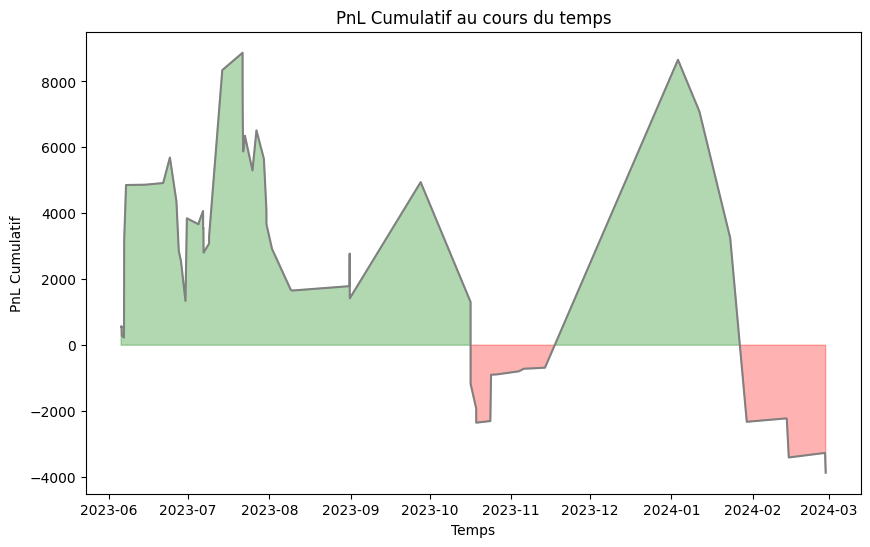

In [86]:
# Trier les données par 'close_time'
dtrades = dtrades.sort_values(by='close_time')

# Calculer le PnL cumulatif
dtrades['cumulative_pnl'] = dtrades['pnl'].cumsum()

# Créer la figure et l'axe
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer la courbe du PnL cumulatif
ax.plot(dtrades['close_time'], dtrades['cumulative_pnl'], label='PnL cumulatif au cours du temps', color='gray')  # ligne en gris pour la visibilité

# Ajout d'un remplissage coloré
cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "green"])
norm = plt.Normalize(dtrades['cumulative_pnl'].min(), dtrades['cumulative_pnl'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax.fill_between(dtrades['close_time'], 0, dtrades['cumulative_pnl'], where=(dtrades['cumulative_pnl'] >= 0), color='green', interpolate=True, alpha=0.3)
ax.fill_between(dtrades['close_time'], 0, dtrades['cumulative_pnl'], where=(dtrades['cumulative_pnl'] <= 0), color='red', interpolate=True, alpha=0.3)

# Ajouter des titres et des labels
ax.set_title('PnL Cumulatif au cours du temps')
ax.set_xlabel('Temps')
ax.set_ylabel('PnL Cumulatif')

plt.show()

In [87]:
# dtrades.loc[dtrades["close_time"] > "2023-12"].iloc[:50]
# dtrades[dtrades["pnl"] > 500]

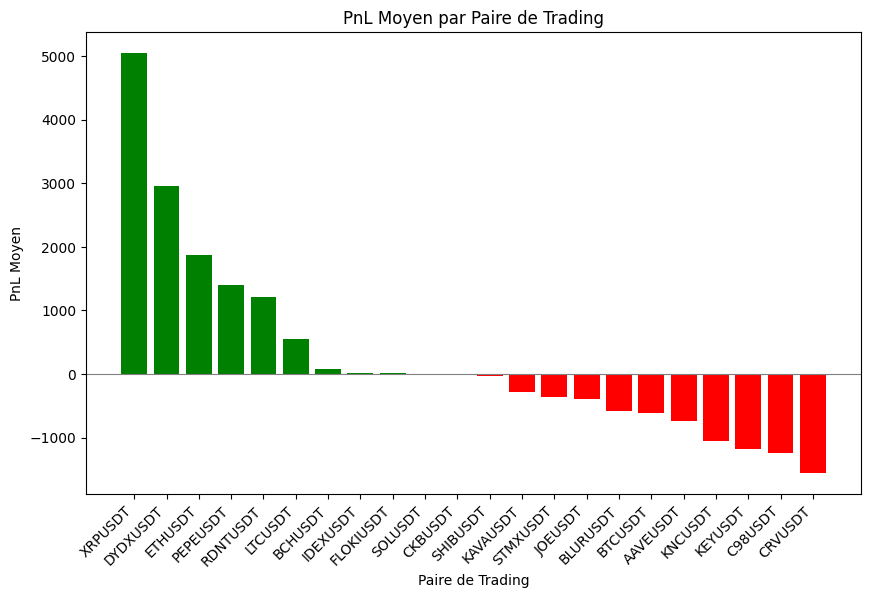

In [88]:
# Calculer le PnL moyen par paire
average_pnl = dtrades.groupby('pair')['pnl'].mean().reset_index()

# Trier les résultats par PnL moyen pour une meilleure visualisation
average_pnl_sorted = average_pnl.sort_values(by='pnl', ascending=False)

# Définir les couleurs en fonction du PnL moyen: vert si positif, rouge si négatif
colors = ['green' if x > 0 else 'red' for x in average_pnl_sorted['pnl']]

# Créer un bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_pnl_sorted['pair'], average_pnl_sorted['pnl'], color=colors)
plt.xlabel('Paire de Trading')
plt.ylabel('PnL Moyen')
plt.title('PnL Moyen par Paire de Trading')
plt.axhline(0, color='gray', linewidth=0.8)  # Ajoute une ligne à y=0 pour mieux visualiser les gains/pertes
plt.xticks(rotation=45, ha='right')  # Rotation et alignement des étiquettes pour une meilleure lisibilité
plt.show()

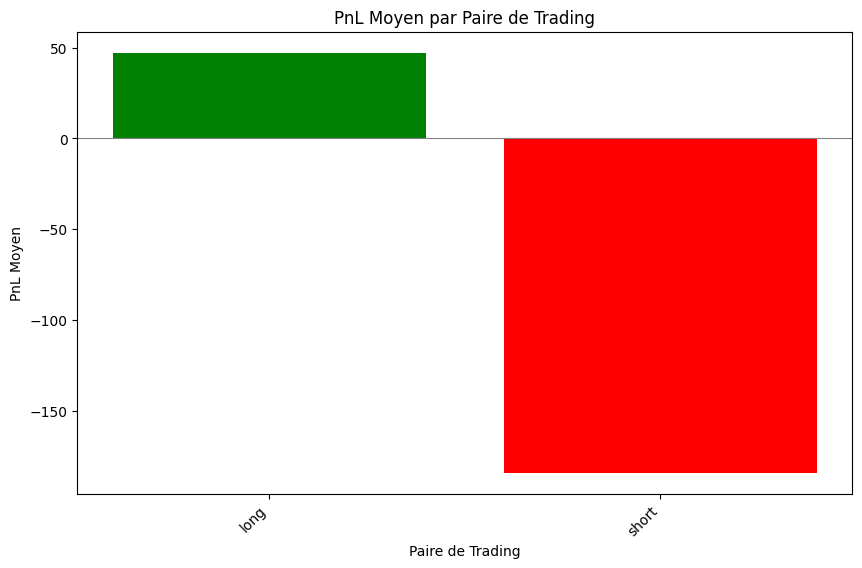

In [89]:
# Calculer le PnL moyen par paire
average_pnl = dtrades.groupby('side')['pnl'].mean().reset_index()

# Trier les résultats par PnL moyen pour une meilleure visualisation
average_pnl_sorted = average_pnl.sort_values(by='pnl', ascending=False)

# Définir les couleurs en fonction du PnL moyen: vert si positif, rouge si négatif
colors = ['green' if x > 0 else 'red' for x in average_pnl_sorted['pnl']]

# Créer un bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_pnl_sorted['side'], average_pnl_sorted['pnl'], color=colors)
plt.xlabel('Paire de Trading')
plt.ylabel('PnL Moyen')
plt.title('PnL Moyen par Paire de Trading')
plt.axhline(0, color='gray', linewidth=0.8)  # Ajoute une ligne à y=0 pour mieux visualiser les gains/pertes
plt.xticks(rotation=45, ha='right')  # Rotation et alignement des étiquettes pour une meilleure lisibilité
plt.show()

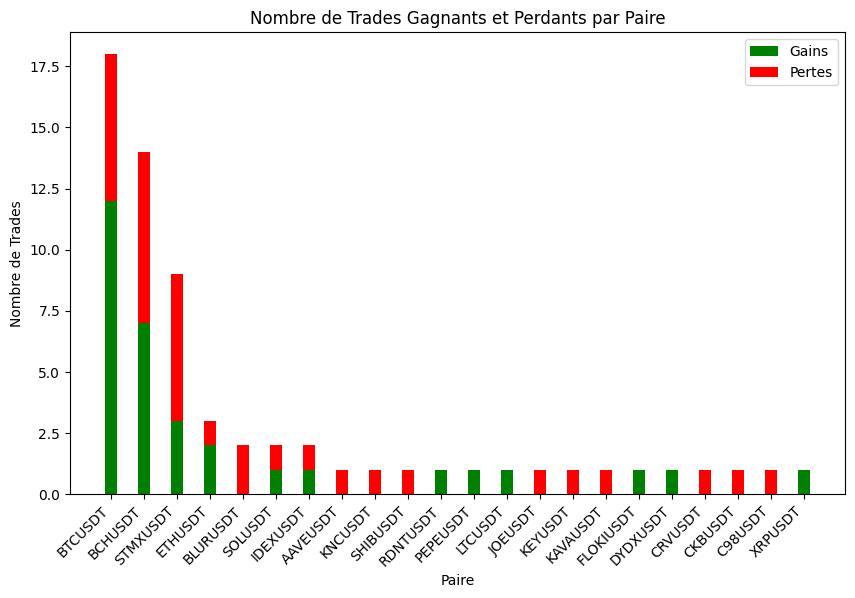

In [90]:


result = dtrades.groupby('pair')['pnl'].agg(
    wins=lambda x: (x > 0).sum(),
    losses=lambda x: (x < 0).sum()
).reset_index()

# Ajouter une colonne pour le nombre total de trades
result['total_trades'] = result['wins'] + result['losses']

# Trier les résultats par le nombre total de trades
result_sorted = result.sort_values(by='total_trades', ascending=False)

# Créer un graphique en barres empilées
fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(result_sorted['pair']))
bar_width = 0.35

rects1 = ax.bar(index, result_sorted['wins'], bar_width, label='Gains', color='green')
rects2 = ax.bar(index, result_sorted['losses'], bar_width, bottom=result_sorted['wins'], label='Pertes', color='red')

ax.set_xlabel('Paire')
ax.set_ylabel('Nombre de Trades')
ax.set_title('Nombre de Trades Gagnants et Perdants par Paire')
ax.set_xticks(index)
ax.set_xticklabels(result_sorted['pair'], rotation=45, ha='right')
ax.legend()

plt.show()

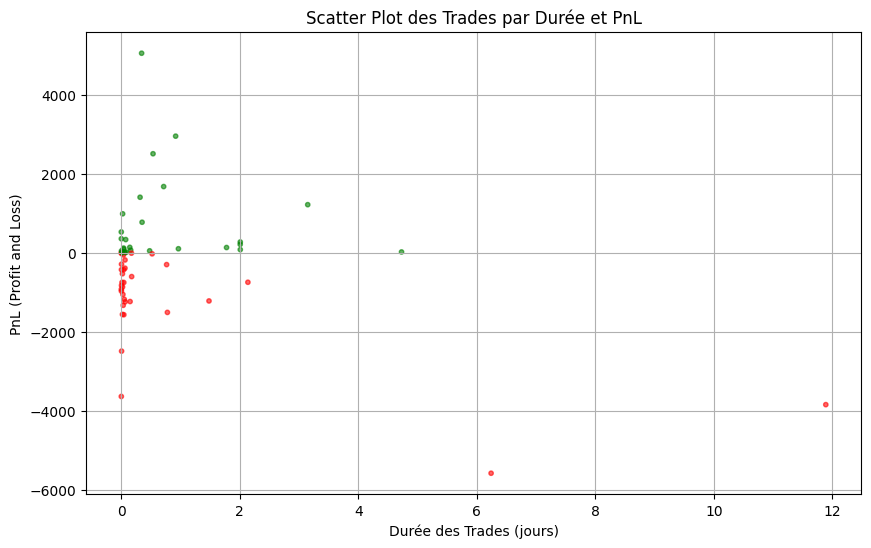

In [92]:
import numpy as np

# Déterminer la couleur en fonction du pnl
colors = ['green' if x > 0 else 'red' for x in dtrades['pnl']]
# dtrades = dtrades[dtrades["duration"] < 50]
# Création du scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dtrades['duration'], dtrades['pnl'], color=colors, alpha=0.6, s=10)
plt.title('Scatter Plot des Trades par Durée et PnL')
plt.xlabel('Durée des Trades (jours)')
plt.ylabel('PnL (Profit and Loss)')

# Ajouter une grille pour meilleure lisibilité
plt.grid(True)

plt.show()